In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def main():

    '''
    The main program flow
    '''

    library = init() #Initialize with Lattice_Information.txt
    kpath_matrix, lattice_type, kpath, total_kpoints = ask(library) #Get parameters from user
    all_kpath, number, N = generate_kpath(kpath_matrix, total_kpoints) #Generate kpoints between kpath's high symmetry points
    write_file(all_kpath, number, lattice_type, kpath) #Write 2 files: KPOINTS and klabel

def init():

    '''
    Initialize the lattice types and the k points library through Lattice_Information.txt
    '''

    file_name = 'Lattice_Information.txt' #Lattice_Information.txt records some lattice types and their k points

    lines = read_file(file_name)
    library = tranform_lines_into_library(file_name, lines)

    return library

def read_file(file_name):

    '''
    A function which reads the Lattice_Information.txt file and return lines
    '''
    
    try:
        with open(file_name, 'r') as fh:
            lines = fh.readlines()

    except:
        sys.stderr.write(f'{file_name} is Not Found')
    
    return lines

def tranform_lines_into_library(file_name, lines):

    '''
    A function which transforms lines into the standard form of library and return library
    '''

    library = {} #collect the information of the lattice types and the k points
    
    for line in lines:

        line = line.split()

        if len(line) == 1: #the length of the line = 1 means the line contains the information of the lattice type
            lattice_type = line[0]
            library[lattice_type] = {}
        elif len(line) == 4: #the length of the line = 4 means the line contains the information of the k point
            high_symmetry_kpoint = line[0]
            library[lattice_type][high_symmetry_kpoint] = np.array(line[1:4], dtype = 'float')
        else:
            print(f'There are some problems in the {file_name} file')

    return library

def ask(library):
    
    lattice_type = ask_lattice_type(library)
    
    kpath_matrix, kpath = ask_kpath(library, lattice_type)
    
    total_kpoints = ask_total_kpoints(kpath_matrix)
    
    return kpath_matrix, lattice_type, kpath, total_kpoints

def ask_lattice_type(library):

    '''
    To ask kpath from user
    '''

    while True:
        
        lattice_type = input(f'Enter the lattice type in the lattice type library {tuple(library.keys())} \n')
        
        if lattice_type in library.keys():
            break
        else:
            print(f'There is no \'{lattice_type}\' lattice type in the lattice type library {tuple(library.keys())}')

    return lattice_type

def ask_kpath(library, lattice_type):

    '''
    The function can collect kpath from user
    '''

    while True:
        
        kpath = input(f'Enter the kpath with the string form \n{tuple(library[lattice_type])}\n')
        kpath_matrix = np.zeros(shape=(len(kpath),3))
        all_correct = True

        for i, k in enumerate(kpath):

            if k in library[lattice_type]:
                kpath_matrix[i] = library[lattice_type][k]
            else:
                all_correct = False
                print(f'{k} doesn\'t exist in {tuple(library[lattice_type].keys())}')
        
        if all_correct == True:
            break

    return kpath_matrix, kpath

def ask_total_kpoints(kpath_matrix):
    
    kpath_delta = kpath_matrix[1:] - kpath_matrix[0:-1]
    length = np.linalg.norm(kpath_delta, axis = 1)
    
    weight = np.array(np.round(length*100),dtype='int32')
    gcd = np.gcd.reduce(weight)
    weight //= gcd
    recommend = weight.sum()
    
    try:
        total_kpoints = int(input(f'Enter total kpoints (Recommened:{recommend}*N+1 where N is integer)\n'))
    except:
        sys.stderr.write('Invalid argumets!\n')
        
    return total_kpoints

def generate_kpath(kpath_matrix, total_kpoints):

    kpath_delta = kpath_matrix[1:] - kpath_matrix[0:-1]
    length = np.linalg.norm(kpath_delta, axis = 1)
    
    partition = np.round((total_kpoints-1)*(length/length.sum()))
    partition = np.array(partition,dtype='int32')
    N = total_kpoints-1-partition.sum() #The kpoints which are still not arrange
    I = np.identity(partition.shape[0],dtype='int32')
    
    if N>0:
    
        for i in range(N):
        
            all_partition = partition+I
        
            density = all_partition/length
            den_std = np.std(density,axis=1)
        
            partition = all_partition[den_std==min(den_std)][0]
            
    elif N<0:
    
        for i in range(-N):
        
            all_partition = partition-I
        
            density = all_partition/length
            den_std = np.std(density,axis=1)
        
            partition = all_partition[den_std==min(den_std)][0]
            
    else:
        pass
        
    all_kpath = np.zeros(shape=(total_kpoints,3))
    
    number = [0]
    
    for ki, kf, p in zip(kpath_matrix[0:-1],kpath_matrix[1:],partition):
        
        i = number[-1]
        
        all_kpath[i:i+p] = np.linspace(ki,kf,p,endpoint=False)
        
        number.append(i + p)
        
    all_kpath[-1] = kpath_matrix[-1]
    
    return all_kpath, number, N

def write_file(all_kpath, number, lattice_type, kpath):

    filename = input('Enter the filename to save file\n')
    
    write_KPOINTS(filename, all_kpath)

    write_klabel(filename, lattice_type, kpath, number)

def write_KPOINTS(filename, all_kpath):
    
    with open(f'KPOINTS_{filename}', 'w') as fh:
        
        line = f'{filename}'
        fh.write(line+'\n')
        line = '2'
        fh.write(line+'\n')
        line = 'Line-mode'
        fh.write(line+'\n')
        line = 'Cartesian'
        fh.write(line+'\n')
        
        for k in all_kpath:
            
            kx   = k[0]
            line = f'{kx:7f}' + ' '*(10 - len(f'{kx:7f}'))
            ky   = k[1]
            line += f'{ky:7f}' + ' '*(10 - len(f'{ky:7f}'))
            kz   = k[2]
            line += f'{kz:7f}'
            
            fh.write(line+'\n')
            
    print(f'Successfully create the KPOINTS_{filename} file!')

def write_klabel(filename, lattice_type, kpath, number):

    with open('klabel', 'w') as fh:

        fh.write(lattice_type+'\n')

        number = list(number)
        number.insert(0, 0)
        num = 0

        for k, n in zip(kpath, number):

            num += int(n)
            
            if len(k) == 1:
                line = k + ' '
            else:
                line = k[0] + ' '
                line += k[1] + ' '
                line += k[2] + ' '
            
            line += str(num) + ' '*(8 - len(str(num)))
            fh.write(line+'\n')

    print(f'Successfully create the klabel file!')


In [3]:
main()

Enter the lattice type in the lattice type library ('S', 'B', 'F', 'H', 'T') 
H
Enter the kpath with the string form 
('G', 'A', 'K', 'H', 'M', 'L')
GAKHML
Enter total kpoints (Recommened:108*N+1 where N is integer)
6
Enter the filename to save file
Ti
Successfully create the KPOINTS_Ti file!
Successfully create the klabel file!


In [4]:
library = init() #Initialize with Lattice_Information.txt
kpath_matrix, lattice_type, kpath, total_kpoints = ask(library) #Get parameters from user

Enter the lattice type in the lattice type library ('S', 'B', 'F', 'H', 'T') 
H
Enter the kpath with the string form 
('G', 'A', 'K', 'H', 'M', 'L')
GAKHML\
\ doesn't exist in ('G', 'A', 'K', 'H', 'M', 'L')
Enter the kpath with the string form 
('G', 'A', 'K', 'H', 'M', 'L')
GAKHML
Enter total kpoints (Recommened:108*N+1 where N is integer)
6


In [32]:
ks = np.arange(99,120)
Ns = []
for k in ks:
    all_kpath, number, N = generate_kpath(kpath_matrix, k)
    Ns.append(N)
    
Ns = np.array(Ns)

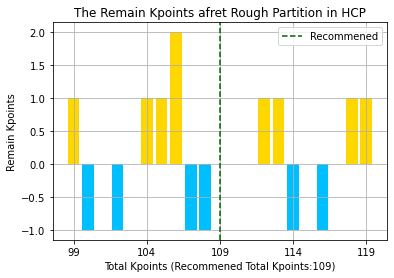

In [53]:
c = np.full(Ns.shape[0],'gold',dtype='U25')
c[Ns<0] = 'deepskyblue'
plt.bar(ks,Ns,color=c)
plt.axvline(109,linestyle='--',color='darkgreen',label='Recommened')
plt.title('The Remain Kpoints afret Rough Partition in HCP')
plt.xlabel('Total Kpoints (Recommened Total Kpoints:109)')
plt.ylabel('Remain Kpoints')
plt.xticks(ks[::5],ks[::5])
plt.grid()
plt.legend()
plt.savefig('Test.png',format='png');

In [48]:
c

array(['orange', 'deepskyblue', 'orange', 'deepskyblue', 'orange',
       'orange', 'orange', 'orange', 'deepskyblue', 'deepskyblue',
       'orange', 'orange', 'orange', 'orange', 'orange', 'deepskyblue',
       'orange', 'deepskyblue', 'orange', 'orange', 'orange'],
      dtype='<U25')